In [1]:
from tensorflow import __version__ as tf_version
from keras import __version__ as keras_version

print(f'keras_version=={keras_version}, tf_version=={tf_version}')

keras_version==2.2.0, tf_version==1.10.0


Using TensorFlow backend.


In [2]:
import csv
import os

from efficientnet import EfficientNetB3 as Net
from keras import Sequential, layers, optimizers
from numpy import argmax
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from IPython.display import Image
import matplotlib.pyplot as plt
# IPython magic command:
%matplotlib inline
# get_ipython().run_line_magic('matplotlib', 'inline')

BATCH_SIZE = 32
WIDTH = 150
HEIGHT = 150
EPOCHS = 10
NUM_TRAIN = 8144
NUM_TEST = 7453
DROPOUT_RATE = 0.2
INPUT_SHAPE = (HEIGHT, WIDTH, 3)
NFROZEN_LAYERS=50

In [3]:
# Dataset generators:

names_list = './dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/names.csv'

train_dir = './dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/car_data/train'
validation_dir = './dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/car_data/validation'
test_dir = './dataset/stanford-car-kaggle/stanford-car-dataset-by-classes-folder/car_data/test'

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 8144 images belonging to 196 classes.
Found 7453 images belonging to 196 classes.


In [4]:
# Convnet model:

conv_base = Net(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

'''
Set and print number of frozen layers of base efficientnet model.
'''
plot_model(conv_base, to_file='./output/conv_base.png', show_shapes=True)
Image(filename='./output/conv_base.png')

print(f'\nconv_base.layers length: {len(conv_base.layers)}')

for layer in conv_base.layers[:NFROZEN_LAYERS]:
    layer.trainable = False

trainable_layers = 0
for layer in conv_base.layers:
    if layer.trainable:
        trainable_layers += 1

print(f'Left last {trainable_layers} layers of conv_base trainable.')

'''
After these base layers are added to new Sequential(),
they will be interpreted as a unit.
'''
model = Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D())
if DROPOUT_RATE: model.add(layers.Dropout(DROPOUT_RATE))
model.add(layers.Dense(196, activation="softmax"))

print(f'model.layers length: {len(model.layers)}')

'''
Compile and train model.
'''
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
              metrics=['accuracy'])

plot_model(model, to_file='./output/model.png', show_shapes=True)
Image(filename='./output/model.png')

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //BATCH_SIZE,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

os.makedirs("./models", exist_ok=True)
model.save('./models/efficientnet_stanford_car.h5')

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
conv_base.layers length: 246
Left last 196 layers of conv_base trainable.
model.layers: 4
4 trainable layers.


/home/tbmreza/development/efficientnet_keras_transfer_learning/keras220_env/lib/python3.6/site-packages/keras/engine/training_generator.py:44: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
40/41 [============================>.] - ETA: 4s - loss: 7.3046 - acc: 0.0135

/home/tbmreza/development/efficientnet_keras_transfer_learning/keras220_env/lib/python3.6/site-packages/keras/engine/training_generator.py:272: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


41/41 [==============================] - 240s 6s/step - loss: 7.2637 - acc: 0.0132 - val_loss: 5.3045 - val_acc: 0.0063
Epoch 2/5
41/41 [==============================] - 223s 5s/step - loss: 5.7080 - acc: 0.0091 - val_loss: 6.2587 - val_acc: 0.0031
Epoch 3/5
41/41 [==============================] - 223s 5s/step - loss: 5.6374 - acc: 0.0183 - val_loss: 5.2800 - val_acc: 0.0063
Epoch 4/5
41/41 [==============================] - 227s 6s/step - loss: 5.4484 - acc: 0.0234 - val_loss: 5.2900 - val_acc: 0.0063
Epoch 5/5
41/41 [==============================] - 226s 6s/step - loss: 5.2559 - acc: 0.0396 - val_loss: 5.2878 - val_acc: 0.0073


NameError: name 'acc' is not defined

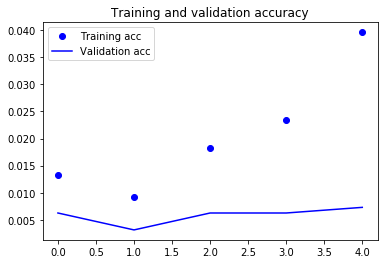

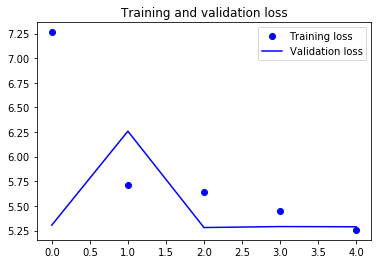

In [5]:
ACC = history.history['acc']
VAL_ACC = history.history['val_acc']
LOSS = history.history['loss']
VAL_LOSS = history.history['val_loss']
EPOCHS_X = range(len(ACC))

plt.plot(EPOCHS_X, ACC, 'bo', label='Training acc')
plt.plot(EPOCHS_X, VAL_ACC, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(EPOCHS_X, LOSS, 'bo', label='Training loss')
plt.plot(EPOCHS_X, VAL_LOSS, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
# Predict:

def standard_path(astring) -> str:
    if astring.endswith('/'):
        return astring

    return astring+'/'


def csv_to_dicts(filename) -> dict:
    class_dict = {}
    with open(filename, mode='r') as infile:
        reader = csv.reader(infile)
        class_index = 0
        for row in reader:
            class_dict[class_index] = row
            class_index += 1

    return class_dict


def predict_image(image_path) -> list:
    img = image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)
    x /= 255.
    top1_index = argmax(model.predict([x])[0])
    class_dict = csv_to_dicts(names_list)
    verdict = class_dict[top1_index]
    print verdict
    return verdict[0]


def test_accuracy():
    '''
    All images in test folder.
    Run predict_image folder by folder.
    '''
    correct = 0
    categories = os.listdir(test_dir)
    total = len(categories)
    assert total == 196

    for folder in categories:
        folder_path = standard_path(test_dir)+standard_path(folder)
        for image_file in os.listdir(folder_path):
            image_path = folder_path+image_file
            verdict = predict_image(image_path)
            
            if folder.lower() == verdict.lower():
                print(f'folder: {folder}, verdict: {verdict}')
                correct += 1

    return f'Test accuracy: {correct/total*100}%'

In [17]:
test_accuracy()

[[0.00234331 0.00375328 0.00494807 0.00672196 0.00810993 0.00628929
  0.00332706 0.004875   0.00652695 0.00411973 0.00325417 0.00252289
  0.00591252 0.00751074 0.00662252 0.00559086 0.00734106 0.00288705
  0.00404228 0.00223016 0.00416538 0.00392772 0.00482218 0.00460603
  0.0024228  0.00369261 0.00632574 0.00371385 0.00514254 0.00347128
  0.00583923 0.00584692 0.00497962 0.01148085 0.00342376 0.0034651
  0.00294549 0.00377588 0.00466111 0.00889025 0.00314229 0.00466282
  0.00396709 0.00384035 0.00548442 0.00467569 0.00530586 0.00382714
  0.00393547 0.0046271  0.00303123 0.003205   0.00396835 0.00451963
  0.00638088 0.00635854 0.00401903 0.00470178 0.00669983 0.00358101
  0.0019984  0.00391858 0.00645138 0.00900029 0.01073194 0.01216848
  0.00193155 0.00180391 0.00310757 0.00489572 0.00246714 0.00424629
  0.00204891 0.00404397 0.00745629 0.00435386 0.00929784 0.00755795
  0.00651257 0.00512717 0.00634354 0.00357725 0.00596107 0.00381891
  0.00788476 0.00524712 0.00509002 0.00435835 0.0

[[0.00234928 0.00324742 0.00472258 0.00677516 0.00825754 0.00849844
  0.00411591 0.00632973 0.00757169 0.00392075 0.00328468 0.00288075
  0.00572958 0.00690875 0.00962207 0.00416889 0.00599401 0.00376286
  0.00504449 0.00281803 0.0039437  0.00452335 0.00553648 0.00542262
  0.00263    0.00369747 0.00661704 0.00463269 0.00491636 0.00377957
  0.00526479 0.00520848 0.00557903 0.00940293 0.00437026 0.00407647
  0.00388634 0.00423698 0.0046144  0.00899212 0.00405745 0.00493729
  0.00427218 0.00372401 0.00380259 0.0060349  0.00578163 0.00511601
  0.00350429 0.00526477 0.00468999 0.0036158  0.0049908  0.00514773
  0.0072049  0.00491459 0.00383701 0.00581823 0.00590051 0.00386309
  0.00197786 0.00430268 0.00630629 0.00859246 0.00848075 0.01064593
  0.00180181 0.0019395  0.00291721 0.00342792 0.00257921 0.00398038
  0.00230546 0.00381377 0.00619459 0.00369309 0.00770784 0.00631995
  0.00557199 0.00597656 0.00594238 0.0037059  0.00448673 0.00381197
  0.0065306  0.00605119 0.00486989 0.00360484 0.

[[0.00353754 0.00367591 0.00592075 0.00617164 0.00792573 0.00701757
  0.00485621 0.00617514 0.00676217 0.00484781 0.00394062 0.00314163
  0.00617045 0.00624988 0.00902601 0.00561798 0.00559268 0.00450526
  0.004532   0.00388765 0.00384907 0.00445646 0.00537049 0.00571739
  0.00363662 0.00471131 0.00529907 0.00555506 0.00552132 0.00465999
  0.00534449 0.00481421 0.00614922 0.00670416 0.00470789 0.00480228
  0.00418975 0.00487829 0.00576146 0.00762733 0.00454304 0.00474817
  0.004915   0.00472644 0.00487764 0.00644524 0.00658865 0.00617415
  0.00379937 0.00515842 0.00532385 0.00396296 0.00559919 0.005256
  0.00562161 0.00547778 0.00431227 0.00380213 0.00641708 0.00380502
  0.00264795 0.00444281 0.00599421 0.0071795  0.00784975 0.00744809
  0.0025858  0.00269743 0.0034067  0.00386847 0.00301184 0.00456707
  0.00367652 0.00478121 0.00628257 0.00488321 0.00786752 0.00637861
  0.0053299  0.00597788 0.00619704 0.00458393 0.0048589  0.0047859
  0.00545309 0.00551283 0.00552289 0.00492845 0.003

[[0.00240736 0.00362231 0.00553834 0.00683145 0.00859679 0.00911503
  0.00445371 0.00476487 0.00796612 0.0045097  0.00282953 0.00271327
  0.00631203 0.00753382 0.00882973 0.00450182 0.00672829 0.00331164
  0.00509683 0.00243788 0.00452265 0.00446922 0.00496954 0.00550365
  0.00227729 0.00344095 0.00603787 0.00388652 0.0049744  0.00433319
  0.00548042 0.00607092 0.00574256 0.0093866  0.00415841 0.00337358
  0.00328721 0.00400865 0.00407525 0.00797339 0.00348143 0.00419746
  0.00398044 0.00376678 0.00411612 0.00628849 0.00533792 0.00468165
  0.0032261  0.00488308 0.00376275 0.00337102 0.00472051 0.00510598
  0.00657376 0.00453128 0.00395167 0.00511955 0.00663482 0.00373108
  0.001802   0.00433193 0.00576357 0.00940967 0.00834765 0.01111537
  0.0016203  0.00172152 0.00273543 0.00359888 0.00216755 0.00378129
  0.00239142 0.00362655 0.0070002  0.00406584 0.00790458 0.00657101
  0.00574701 0.00650696 0.00650658 0.00310633 0.00470001 0.00401546
  0.0062209  0.00548098 0.00462617 0.00397499 0.

[[0.0029147  0.00350435 0.0059726  0.00719711 0.00927947 0.00603566
  0.00458591 0.00349515 0.00813525 0.00464853 0.00255909 0.00361949
  0.0058749  0.00993697 0.00893896 0.00541446 0.00529475 0.00353264
  0.0064097  0.0042601  0.00577758 0.00424144 0.00661777 0.00507477
  0.00270142 0.00425768 0.00700382 0.00443968 0.00509121 0.00444429
  0.00523427 0.00779183 0.00590585 0.01024242 0.00335272 0.00373757
  0.00366866 0.00394413 0.0033644  0.00682113 0.00342201 0.00454039
  0.00452274 0.00407551 0.0049012  0.00698692 0.00550428 0.00387723
  0.00345181 0.00582651 0.00442609 0.00267249 0.00478252 0.00409133
  0.00586925 0.0055408  0.00480505 0.00423419 0.00911201 0.00345253
  0.00170452 0.00319969 0.00614437 0.0109918  0.00789697 0.01005919
  0.00190928 0.00190762 0.00366942 0.00272595 0.00241923 0.00516301
  0.00279626 0.00355962 0.00585368 0.00448007 0.00725813 0.00637135
  0.00640653 0.00574697 0.00597976 0.00397999 0.00478824 0.00478894
  0.00569607 0.00698555 0.0051939  0.00451321 0.

[[0.00168423 0.00336719 0.00507593 0.00665621 0.00865473 0.00863792
  0.00318822 0.00481494 0.00732501 0.00400156 0.00259347 0.00246342
  0.00638388 0.00845815 0.00862472 0.00378211 0.00650803 0.00287245
  0.00465825 0.00152833 0.00390293 0.00417702 0.00443242 0.0058087
  0.00218979 0.00365516 0.00636412 0.00382887 0.00505424 0.00357889
  0.00471566 0.0058576  0.00590996 0.01086781 0.00385064 0.00392885
  0.00366453 0.00375838 0.00357587 0.00990866 0.00307255 0.00430175
  0.00348659 0.00296066 0.00476979 0.00545928 0.00608532 0.00429953
  0.00330771 0.00465655 0.00408274 0.0028336  0.00471667 0.00543691
  0.00616827 0.00464728 0.0031999  0.00569118 0.00624264 0.00341359
  0.00174175 0.00368382 0.00717169 0.0100675  0.0111745  0.01263114
  0.00158548 0.00182568 0.00282868 0.00451476 0.00199919 0.00450011
  0.00169947 0.00367439 0.00666383 0.00372783 0.00870808 0.00752053
  0.00615602 0.00691541 0.00690563 0.00342625 0.0047878  0.00387246
  0.00779496 0.00472463 0.00462197 0.00329761 0.0

[[0.00192754 0.00359378 0.0055019  0.00557002 0.00827497 0.00790196
  0.0038192  0.00526935 0.00735903 0.00395241 0.00299094 0.00342428
  0.00602068 0.00686148 0.00909481 0.00527136 0.00584333 0.00332956
  0.00515167 0.00232774 0.00426218 0.00401647 0.00556694 0.00656635
  0.00273768 0.00424831 0.00622617 0.00438201 0.00544815 0.00448147
  0.00520006 0.00686393 0.00609288 0.00894291 0.00408605 0.00368678
  0.00431234 0.00393362 0.00381122 0.00770473 0.00304566 0.00490368
  0.00382196 0.00406125 0.00469881 0.00546006 0.00578415 0.00485044
  0.00409525 0.00555772 0.00501566 0.00283705 0.00434458 0.00592429
  0.00619193 0.00551492 0.00386611 0.00494643 0.0081147  0.00333228
  0.0018681  0.00407404 0.00587111 0.00721112 0.00939025 0.01012309
  0.00226896 0.00244623 0.00263369 0.00348345 0.00230936 0.00414229
  0.00216356 0.00413128 0.00610879 0.00465995 0.00804516 0.00642372
  0.00691777 0.00708525 0.00608201 0.00364851 0.00494244 0.00375362
  0.00685907 0.00592521 0.00549028 0.00396235 0.

[[0.00216739 0.00391562 0.00508864 0.00542297 0.00758824 0.00758105
  0.00422175 0.00651287 0.00650651 0.0038339  0.00286291 0.00277971
  0.0062466  0.00758616 0.00800814 0.00446793 0.00624462 0.0035285
  0.00534794 0.00220354 0.00403224 0.00417852 0.00540049 0.00579649
  0.00254306 0.00408821 0.00638526 0.00496581 0.00533093 0.00420874
  0.00485053 0.00602625 0.00724421 0.00888157 0.00382131 0.00390494
  0.00443534 0.00451794 0.00418255 0.00866195 0.00353346 0.00495269
  0.0032645  0.00386574 0.00381364 0.00533657 0.00607463 0.00474361
  0.00322424 0.00536243 0.00466031 0.00308004 0.00423143 0.0054101
  0.00622203 0.00485236 0.00423113 0.00449296 0.00662671 0.00385549
  0.00166579 0.00433191 0.00622109 0.00714185 0.00842764 0.00922062
  0.00180109 0.00215383 0.00246286 0.003838   0.00245438 0.004797
  0.00248477 0.00382551 0.00641147 0.00445164 0.00800966 0.00782995
  0.00664412 0.00713527 0.00674262 0.00329345 0.00504518 0.00432834
  0.00752367 0.0049086  0.00549842 0.00426945 0.0022

[[0.00243544 0.00323874 0.00534322 0.00569079 0.00905652 0.00796269
  0.00378178 0.00512693 0.00604501 0.00444928 0.00289783 0.0029992
  0.00591765 0.0073326  0.00740396 0.00472994 0.00663446 0.00340995
  0.00620137 0.00255886 0.00414149 0.00412401 0.00406513 0.00644416
  0.00286518 0.00458038 0.00517208 0.00464825 0.0067098  0.00434932
  0.00466538 0.00604112 0.00669539 0.0078654  0.00423716 0.00381515
  0.00459346 0.00444035 0.00461603 0.00756817 0.00348175 0.00400953
  0.00333272 0.00388648 0.00448999 0.00512669 0.00621425 0.00573292
  0.00337523 0.00568425 0.00475045 0.00352075 0.0038416  0.00658568
  0.00608933 0.0045596  0.00422406 0.00471043 0.00810929 0.0042751
  0.00199915 0.00521067 0.00588475 0.00821625 0.00875703 0.00888889
  0.00184328 0.00295279 0.0028091  0.0041341  0.00259275 0.00426267
  0.00302278 0.00406703 0.00583462 0.00489287 0.00832049 0.00597026
  0.00644564 0.00641932 0.00593016 0.00359522 0.00530694 0.00429222
  0.00565312 0.00576806 0.00517638 0.00472866 0.00

[[0.00207997 0.00345214 0.00482901 0.00669615 0.00865805 0.00822861
  0.00327948 0.00467673 0.00655021 0.00393946 0.00281019 0.00252612
  0.0056868  0.00832782 0.007895   0.0041992  0.00549352 0.00314013
  0.0049553  0.00200618 0.00427948 0.00402623 0.00427017 0.00594247
  0.00233961 0.00396311 0.00531893 0.0038279  0.00634982 0.00385164
  0.00476466 0.00591035 0.00653205 0.00797151 0.00431475 0.00364164
  0.00384152 0.00412143 0.00393497 0.00776404 0.0033994  0.0043143
  0.00380224 0.00399172 0.00501065 0.00490164 0.00631893 0.00506245
  0.00330249 0.00469926 0.00423111 0.00309311 0.00487848 0.00566032
  0.00635585 0.00450678 0.00366676 0.00497549 0.0066151  0.00400068
  0.00189463 0.00458094 0.00694632 0.01074081 0.00995544 0.01035869
  0.00182666 0.00233308 0.00280813 0.00467826 0.00267214 0.00421085
  0.00221911 0.00456859 0.00610887 0.00438744 0.00862893 0.00645374
  0.00704823 0.00693165 0.00625273 0.00375777 0.00500703 0.00439314
  0.00663053 0.00514268 0.00501319 0.00360271 0.0

[[0.00193601 0.00300841 0.00521815 0.00643981 0.00931021 0.0081225
  0.00361561 0.00570857 0.0079805  0.00427682 0.00279933 0.00259982
  0.00649812 0.00831395 0.00835947 0.00438007 0.00596347 0.00300521
  0.00568649 0.00218691 0.00439839 0.00384667 0.00461543 0.00684527
  0.00226988 0.00395255 0.00536045 0.00375588 0.00499882 0.00484567
  0.00519165 0.00649838 0.00663593 0.00895084 0.0048905  0.00360558
  0.0036301  0.00418449 0.00416106 0.00948143 0.00292866 0.00444373
  0.00356732 0.00357321 0.00422329 0.00591548 0.00558035 0.00513395
  0.00354977 0.00571892 0.00510516 0.00330696 0.00476679 0.00539985
  0.00645832 0.00388417 0.00345783 0.00517455 0.00720426 0.00314437
  0.00171876 0.00350372 0.00666043 0.00997815 0.00953154 0.01175846
  0.0016098  0.0018183  0.00298467 0.00369937 0.00210513 0.0042585
  0.00233578 0.00354823 0.00693302 0.00459133 0.00971084 0.00620156
  0.00656171 0.00676745 0.00615795 0.00355874 0.00468214 0.00415267
  0.00610417 0.00535403 0.00474271 0.00372871 0.00

[[0.00175516 0.00290575 0.00474053 0.00716495 0.01043583 0.00846551
  0.0046622  0.00562725 0.00757944 0.00398418 0.00295574 0.00276736
  0.00569859 0.00878265 0.01035637 0.00519767 0.00520066 0.00324037
  0.00598577 0.00260467 0.00452447 0.00407474 0.00417628 0.00729241
  0.00240107 0.00421636 0.00584057 0.00367756 0.00516394 0.00487869
  0.00583805 0.00658071 0.00649513 0.00894264 0.0051352  0.0040787
  0.00386519 0.00470552 0.00515522 0.00909946 0.0028868  0.00519631
  0.00374176 0.00436038 0.00406303 0.00749247 0.00665087 0.00554398
  0.00295142 0.00512116 0.00603537 0.00364025 0.00555511 0.00552721
  0.00666977 0.00334212 0.00311309 0.00463633 0.00716881 0.00268432
  0.00158514 0.00307621 0.00641537 0.01174648 0.00760535 0.0102456
  0.00185652 0.00190473 0.00297267 0.00328077 0.00201369 0.00385629
  0.00265729 0.00395662 0.00711739 0.00465287 0.00922148 0.00582919
  0.00610835 0.0065121  0.00597029 0.00292131 0.00376728 0.00403782
  0.00448696 0.00595794 0.00429023 0.00336122 0.00

[[0.00201276 0.00279394 0.00599555 0.00728317 0.01120259 0.00782937
  0.00413012 0.00616434 0.00801243 0.00404974 0.0031294  0.0031276
  0.00665165 0.00766437 0.01017011 0.00480348 0.00544995 0.00389569
  0.00644259 0.00361747 0.00471501 0.00394464 0.00529248 0.00724374
  0.00246916 0.00394917 0.00561805 0.00479722 0.00490767 0.00518318
  0.00672002 0.0065613  0.00620111 0.00837442 0.0051359  0.0037931
  0.00427382 0.00423544 0.00489198 0.00849891 0.00292786 0.00464308
  0.00381357 0.00441745 0.00369881 0.00726198 0.00559832 0.00621878
  0.00337376 0.00625708 0.00612671 0.00374107 0.00493211 0.00608582
  0.00638601 0.00404617 0.00365729 0.00523739 0.00767918 0.00307491
  0.00181455 0.00383356 0.00722884 0.01069094 0.00763898 0.01000302
  0.00175307 0.00192488 0.0030641  0.0029213  0.00224114 0.00401729
  0.00285796 0.00354293 0.00682501 0.00501603 0.00881966 0.00487823
  0.00641151 0.00650259 0.00550271 0.00364006 0.00396872 0.00402399
  0.00481031 0.00612434 0.00480436 0.00331722 0.00

KeyboardInterrupt: 